In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.layers import Dense, Concatenate, LSTM, Lambda

In [ ]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.utils import plot_model

**Model to predict the type of songs - tap dance, ballet etc**

Input - audio and poses of a song
Output - type of song (ballet, tap etc) in the form of one hot encoding.

One hot encoding - Assume there are 4 types of dances- tap, ballet, hip hop and break. Heres how the outputs would look

0001 - tap

0010 - ballet

0100 - hip hop

1000 - break

In [ ]:
import numpy as np
import librosa
import json

In [ ]:
#labelling the data1

import os

folder_path = "/content/drive/MyDrive/Summer_Internship_Data/Datasets"  # Replace with the actual path to your "Datasets" folder
output_array = []

# Iterate over the files in the folder
for filename in sorted(os.listdir(folder_path)):
    if filename.endswith("_data.json"):  # Consider only files ending with "_data.json"
        name = filename.split("_data")[0]  # Extract the name by removing "_data" suffix
        dance_form = ''.join([i for i in name if not i.isdigit()])  # Remove numeric part from the name
        output_array.append(dance_form)


In [ ]:
import os

filenames = sorted(os.listdir('/content/drive/MyDrive/Summer_Internship_Data/Datasets'))

In [ ]:
len(filenames)

25

In [ ]:
filenames = sorted(os.listdir('/content/drive/MyDrive/Summer_Internship_Data/Processed_audios'))
len(filenames)

25

In [ ]:
import os


pose_path = '/content/drive/MyDrive/Summer_Internship_Data/Datasets'
pose_files = os.listdir(pose_path)

pose_data = []
for pose_data_file in pose_files:
  with open(os.path.join(pose_path, pose_data_file), "r") as f:
      pose_data.append(json.load(f))

# Load the audio files and preprocess them (e.g., convert to mel spectrograms)
# audio_files = ["path/to/audio1.wav", "path/to/audio2.wav", ...]
audio_path = '/content/drive/MyDrive/Summer_Internship_Data/Processed_audios'
audio_files = sorted(os.listdir(audio_path))
preprocessed_audio = []
for audio_file in audio_files:
    audio, sr = librosa.load(os.path.join(audio_path, audio_file), sr=None)  # Load audio file
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)  # Convert to mel spectrogram
    preprocessed_audio.append(spectrogram)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np

# Initialize the one-hot encoder
onehot_encoder = OneHotEncoder(sparse=False)

# Fit and transform the output array with one-hot encoder
onehot_encoded = onehot_encoder.fit_transform(np.array(output_array).reshape(-1, 1))


# Print the one-hot encoded array
print(onehot_encoded)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
np.array(preprocessed_audio[0]).shape

(128, 2617)

In [ ]:
np.array(preprocessed_audio[1]).shape

(128, 13205)

In [ ]:
import numpy as np

# Dataset of shape (26, 128, n)
dataset = preprocessed_audio  # Replace ... with the actual variable containing the mel spectrogram data

# Step 1: Find the longest length
max_length = max([audio_clip.shape[1] for audio_clip in dataset])

# Step 2: Insert End of Song token
eos_token = np.zeros((128, 1))  # Assuming 128 is the height of the mel spectrogram
dataset_with_eos = [np.concatenate((audio_clip, eos_token), axis=1) for audio_clip in dataset]

# Step 3: Pad audio clips with 0's
padded_dataset = [np.pad(audio_clip, ((0, 0), (0, max_length - audio_clip.shape[1] + 1)), mode='constant', constant_values=0) for audio_clip in dataset_with_eos]

# Step 4: Convert the list to a numpy array
padded_array = np.array(padded_dataset)

print(padded_array.shape)


(25, 128, 17184)


In [ ]:
min_length = float('inf')  # Initialize with a large value

for pose_data_file in pose_data:
    length = len(pose_data_file)
    if length < min_length:
        min_length = length

print('Minimum length:', min_length)

Minimum length: 911


In [ ]:
pose_data = [np.array(x)[:min_length, :, :] for x in pose_data]

In [ ]:
import numpy as np

# Assuming preprocessed_audio is a list of arrays with varying shapes

# Step 1: Find the maximum shape
max_shape = max([audio.shape for audio in preprocessed_audio])

# Step 2: Truncate or pad the arrays to have the same shape
padded_audio = []
for audio in preprocessed_audio:
    # Pad or truncate the array to the maximum shape
    padded_audio.append(np.pad(audio, [(0, max_shape[0] - audio.shape[0]), (0, max_shape[1] - audio.shape[1])], mode='constant'))

# Step 3: Create the NumPy array with dtype=object
preprocessed_audio = np.array(padded_audio, dtype=object)

**Your audio files are of different lengths and so are your video files. FIX THIS BEFORE GOING AHEAD**

In [ ]:
pose_data = np.array(pose_data, dtype=np.float)
preprocessed_audio = np.array(preprocessed_audio, dtype=np.float)
onehot_encoded = np.array(onehot_encoded, dtype=np.float)

<ipython-input-39-2c6389482fc7>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pose_data = np.array(pose_data, dtype=np.float)
<ipython-input-39-2c6389482fc7>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  preprocessed_audio = np.array(preprocessed_audio, dtype=np.float)
<ipython-input-39-2c6389482fc7>:3: DeprecationWarning: `np.float

In [ ]:
pose_data.shape

(25, 911, 33, 3)

In [ ]:
preprocessed_audio.shape

(25, 128, 17183)

In [ ]:
onehot_encoded.shape

(25, 6)

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [ ]:
# # Custom callback for logging predictions and labels
# class LogPredictions(Callback):
#     def __init__(self, x_train, y_train):
#         super(LogPredictions, self).__init__()
#         self.x_train = x_train
#         self.y_train = y_train

#     def on_epoch_end(self, epoch, logs=None):
#         if (epoch + 1) % 5 == 0:  # Log predictions every 5 epochs
#             indices = np.random.choice(len(self.x_train), size=5, replace=False)
#             x_samples = self.x_train[indices]
#             y_samples = self.y_train[indices]
#             predictions = np.argmax(self.model.predict(x_samples), axis=1)
#             print("Epoch:", epoch + 1)
#             print("Sample predictions:", predictions)
#             print("Sample labels:", y_samples)

NameError: ignored

In [ ]:
# Reshape the input data to match the expected shape
video_input = Input(shape=(911, 33*3))
audio_input = Input(shape=(128, 17183))

num_classes = onehot_encoded.shape[1]  # Adjust based on the shape of onehot_encoded

# Define the LSTM encoder
encoder_lstm = LSTM(units=32, kernel_regularizer=regularizers.l2(0.01))
encoder_output = encoder_lstm(video_input)

# Define the LSTM decoder with initial state
decoder_lstm = LSTM(units=32, kernel_regularizer=regularizers.l2(0.01), return_sequences=True)
decoder_output = decoder_lstm(audio_input, initial_state=[encoder_output, encoder_output])

# Define the output layer
output = Dense(num_classes, activation='softmax')(decoder_output)

# Create the model
model = Model(inputs=[video_input, audio_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape the target data to match the shape of the output tensor
target_data = onehot_encoded.reshape((-1, 1, num_classes))
target_data = np.tile(target_data, (1, 128, 1))

# Shuffle the data
pose_data_shuffled, preprocessed_audio_shuffled, target_data_shuffled = shuffle(pose_data, preprocessed_audio, target_data)

# Reshape the pose data to match the expected shape
pose_data_reshaped = pose_data_shuffled.reshape((-1, 911, 33*3))

# Split the data into training and test sets
split = int(0.8 * len(pose_data_reshaped))  # 80% for training, 20% for testing
X_train_pose, X_test_pose = pose_data_reshaped[:split], pose_data_reshaped[split:]
X_train_audio, X_test_audio = preprocessed_audio_shuffled[:split], preprocessed_audio_shuffled[split:]
y_train, y_test = target_data_shuffled[:split], target_data_shuffled[split:]

# Train the model
model.fit([X_train_pose, X_train_audio], y_train, batch_size=8, epochs=100, validation_split=0.2)
# print("train: ",model.evaluate(x=[X_train_pose, X_train_audio], y=y_test, batch_size=16))
# Evaluate the model
print("test: ",model.evaluate(x=[X_test_pose, X_test_audio], y=y_test, batch_size=16))


Epoch 1/100
2/2 [==============================] - 6s 2s/step - loss: 5.4409 - accuracy: 0.1772 - val_loss: 4.9988 - val_accuracy: 0.4785
Epoch 2/100
2/2 [==============================] - 0s 272ms/step - loss: 4.6837 - accuracy: 0.6772 - val_loss: 4.7370 - val_accuracy: 0.4062
Epoch 3/100
2/2 [==============================] - 0s 193ms/step - loss: 4.1317 - accuracy: 0.8008 - val_loss: 4.6106 - val_accuracy: 0.4121
Epoch 4/100
2/2 [==============================] - 0s 178ms/step - loss: 3.7400 - accuracy: 0.8267 - val_loss: 4.4116 - val_accuracy: 0.3730
Epoch 5/100
2/2 [==============================] - 0s 202ms/step - loss: 3.4079 - accuracy: 0.8628 - val_loss: 4.2463 - val_accuracy: 0.3223
Epoch 6/100
2/2 [==============================] - 0s 294ms/step - loss: 3.1106 - accuracy: 0.9087 - val_loss: 4.0617 - val_accuracy: 0.3008
Epoch 7/100
2/2 [==============================] - 0s 225ms/step - loss: 2.8291 - accuracy: 0.9395 - val_loss: 3.9202 - val_accuracy: 0.3008
Epoch 8/100
2/2 

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 911, 99)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128, 17183)  0           []                               
                                ]                                                                 
                                                                                                  
 lstm_2 (LSTM)                  (None, 32)           16896       ['input_3[0][0]']                
                                                                                                  
 lstm_3 (LSTM)                  (None, 128, 32)      2203648     ['input_4[0][0]',          

In [ ]:
# import tensorflow as tf
# def scheduler(epoch, lr):
#   if epoch < 10:
#     return lr
#   else:
#     return lr * tf.math.exp(-0.1)
#   model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#   callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
#   # Train the model with your data
#   model.fit([pose_data, preprocessed_audio], onehot_encoded, batch_size=16, epochs=100, callbacks=[callback], validation_split=0.2)
# print(model.evaluate(x = [pose_data, preprocessed_audio], y = onehot_encoded, batch_size = 16))

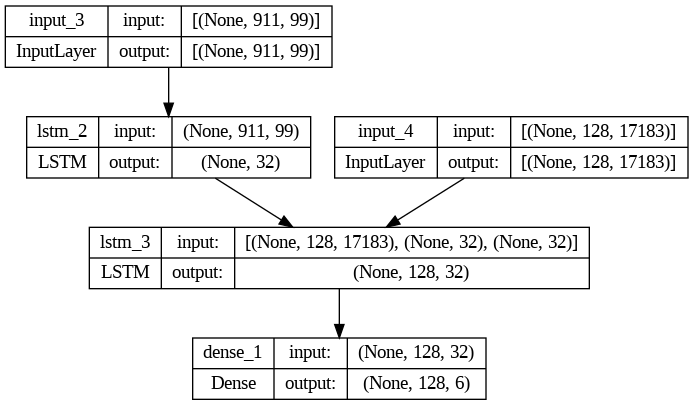

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
model.save('seq2seq.hdf5')

**ML Model for dance to music recommender**



In [ ]:
poses = pose_data.copy()
np.random.shuffle(poses)

audios = preprocessed_audio.copy()
np.random.shuffle(audios)

In [ ]:
num_positive_samples = len(pose_data)
labels_positive = np.ones(num_positive_samples)

num_negative_samples = num_positive_samples
labels_negative = np.zeros(num_negative_samples)

# Combine positive and negative labels
labels = np.concatenate((labels_positive, labels_negative), axis=0)

# Combine pose inputs and audio inputs for positive and negative samples
pose_combined = np.concatenate((pose_data, poses), axis=0)
audio_combined = np.concatenate((preprocessed_audio, audios), axis=0)

combined_data = list(zip(pose_combined, audio_combined, labels))
np.random.shuffle(combined_data)
pose_combined, audio_combined, labels_combined = zip(*combined_data)

pose_combined = np.array(pose_combined)
audio_combined = np.array(audio_combined)
labels_combined = np.array(labels_combined)


In [ ]:
video_input = Input(shape=(911, 33, 3))
audio_input = Input(shape=(128, 17183))

x1 = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(video_input)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Flatten()(x1)

x2 = LSTM(32, kernel_regularizer=regularizers.l2(0.01))(audio_input)

x = Concatenate()([x1, x2])
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dense(1, activation= 'sigmoid')(x)

song_model = Model(inputs = [video_input, audio_input], outputs = x)

In [ ]:
# def scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)

# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [ ]:
import tensorflow as tf

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

class LRSchedulerCallback(tf.keras.callbacks.Callback):
    def set_model(self, model):
        self.model = model

    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        lr.assign(scheduler(epoch, lr))

callback = LRSchedulerCallback()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with your data
model.fit([pose_data, preprocessed_audio], onehot_encoded, batch_size=16, epochs=100, callbacks=[callback], validation_split=0.2)


In [ ]:
song_model.save('song_preds.h5')

In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model('song_preds.h5')

# Assuming pose_data and preprocessed_audio are your test data
# Assuming onehot_encoded is your one-hot encoded labels

# Reshape the test data to match the input shape of the loaded model
pose_data_reshaped = np.reshape(pose_data, (-1, 911, 33, 3))
preprocessed_audio_reshaped = np.reshape(preprocessed_audio, (-1, 128, 17183))

# Make predictions using the loaded model
predictions = loaded_model.predict([pose_data_reshaped, preprocessed_audio_reshaped])

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = np.mean(predicted_classes == np.argmax(onehot_encoded, axis=1))

# Print the accuracy
print('Accuracy:', accuracy)



**Model to predict similarity between 2 songs using Siamese Network**<br/>
Input - there are 4 inputs: audio of song 1, poses of song 1, audio of song 2 and video of song 2. <br/>
Output - A score between 0 & 1 of how similar 2 songs are. <br/>

How to use:
Predict the score for ever pair of songs. If given a song (audio and video) you are asked to recommend another song, just return the song that has the highest similarity score with your given song.

How to train: Watch this youtube video https://www.youtube.com/watch?v=6jfw8MuKwpI&pp=ygUZYW5kcmV3IG5nIHNpYW1lc2UgbmV0d29yaw%3D%3D


In [ ]:
# import tensorflow as tf
# model = tf.keras.models.load('dance_classifier.hdf5')

In [ ]:
# extract_features = Model(inputs = [video_input, audio_input], outputs = model.layers[-2].output)

In [ ]:
# from tensorflow.keras import backend as K

# pose_input_0 = Input(shape=(5384, 33, 3))
# audio_input_0 = Input(shape=(128, 17183))
# pose_input_1 = Input(shape=(5384, 33, 3))
# audio_input_1 = Input(shape=(128, 17183))

# features_1 = extract_features([pose_input_0, audio_input_0])
# features_2 = extract_features([pose_input_1, audio_input_1])

# def cosine_similarity(vectors):
#     x, y = vectors
#     x = K.l2_normalize(x, axis=-1)
#     y = K.l2_normalize(y, axis=-1)
#     return K.sum(x * y, axis=-1, keepdims=True)

# similarity = Lambda(cosine_similarity)([features_1, features_2])

# # Create the Siamese network
# siamese_model = Model(inputs=[pose_input_0, audio_input_0, pose_input_1, audio_input_1], outputs=similarity)

In [ ]:
# plot_model(siamese_model, show_shapes=True)

In [ ]:
# siamese_model.summary()